In [ ]:
import cv2
import dlib
import numpy as np
from imutils import face_utils
from scipy.spatial import distance
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

In [ ]:
#Load model
model = load_model('emotion_detection_model_selected.h5')

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_81_face_landmarks.dat')

class_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
emotion_colors = {
    'Angry': 'red',
    'Happy': 'green',
    'Neutral': 'blue',
    'Sad': 'purple',
    'Surprise': 'orange'
}

polish_labels = {
    'Angry': 'Złość',
    'Happy': 'Szczęście',
    'Neutral': 'Neutralny',
    'Sad': 'Smutek',
    'Surprise': 'Zaskoczenie'
}

emotion_colors = {
    'Złość': 'red',
    'Szczęście': 'green',
    'Neutralny': 'blue',
    'Smutek': 'purple',
    'Zaskoczenie': 'orange'
}

### EAR and MAR functions

In [ ]:
def EAR(points):
    A = distance.euclidean(points[1], points[5])
    B = distance.euclidean(points[2], points[4])
    C = distance.euclidean(points[0], points[3])
    ear = (A + B) / (2.0 * C)
    return ear

def MAR(points):
    A = distance.euclidean(points[13], points[19])
    B = distance.euclidean(points[14], points[18])
    C = distance.euclidean(points[15], points[17])
    D = distance.euclidean(points[12], points[16])
    mar = (A + B + C) / D
    return mar

### Predict emotion function

In [ ]:
def predict_emotion(face):
    face = cv2.resize(face, (48, 48))
    face = face.astype("float") / 255.0
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    preds = model.predict(face)[0]
    emotion_probability = np.max(preds)
    label = class_labels[preds.argmax()]
    return polish_labels[label], emotion_probability

### Analyze video and generate plot function

In [ ]:
def analyze_video(video_path, output_chart_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    interval = int(frame_rate / 5)
    ear_values = []
    mar_values = []
    emotions = []
    frame_numbers = []

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            rects = detector(gray, 0)
            if len(rects) > 0:
                rect = rects[0]
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
                leftEye = shape[42:48]
                rightEye = shape[36:42]
                mouth = shape[48:68]
                ear = (EAR(leftEye) + EAR(rightEye)) / 2.0
                mar = MAR(mouth)
                face = gray[rect.top():rect.bottom(), rect.left():rect.right()]
                emotion, _ = predict_emotion(face)
                ear_values.append(ear)
                mar_values.append(mar)
                emotions.append(emotion)
                frame_numbers.append(frame_count)
        frame_count += 1
    cap.release()

    plt.figure(figsize=(14, 8))
    for i in range(len(frame_numbers)-1):
        plt.plot(frame_numbers[i:i+2], mar_values[i:i+2], color=emotion_colors[emotions[i]], linewidth=1.5)

    plt.plot(frame_numbers, ear_values, label='EAR', color='black', linewidth=1.5)
    
    # EAR MAR legend
    handles = [plt.Line2D([0], [0], color='black', lw=1.5, label='EAR')]
    for emotion, color in emotion_colors.items():
        handles.append(plt.Line2D([0], [0], color=color, lw=1.5, label=emotion))
    plt.legend(handles=handles, title="Emocje dla MAR")
    
    plt.xlabel('Klatka nagrania')
    plt.ylabel('Wartość EAR/MAR')
    plt.title('Wartości EAR i MAR z oznaczonymi emocjami')
    plt.savefig(output_chart_path)
    plt.show()

### Analyze video and generate chart

In [ ]:
#paths for selected video and output chart
video_path = './YAWDD_k/Dash/Dash/Male/3-MaleGlasses.avi'
output_chart_path = './output_chart_3-MaleGlasses.png'
analyze_video(video_path, output_chart_path) 

### View selected chart

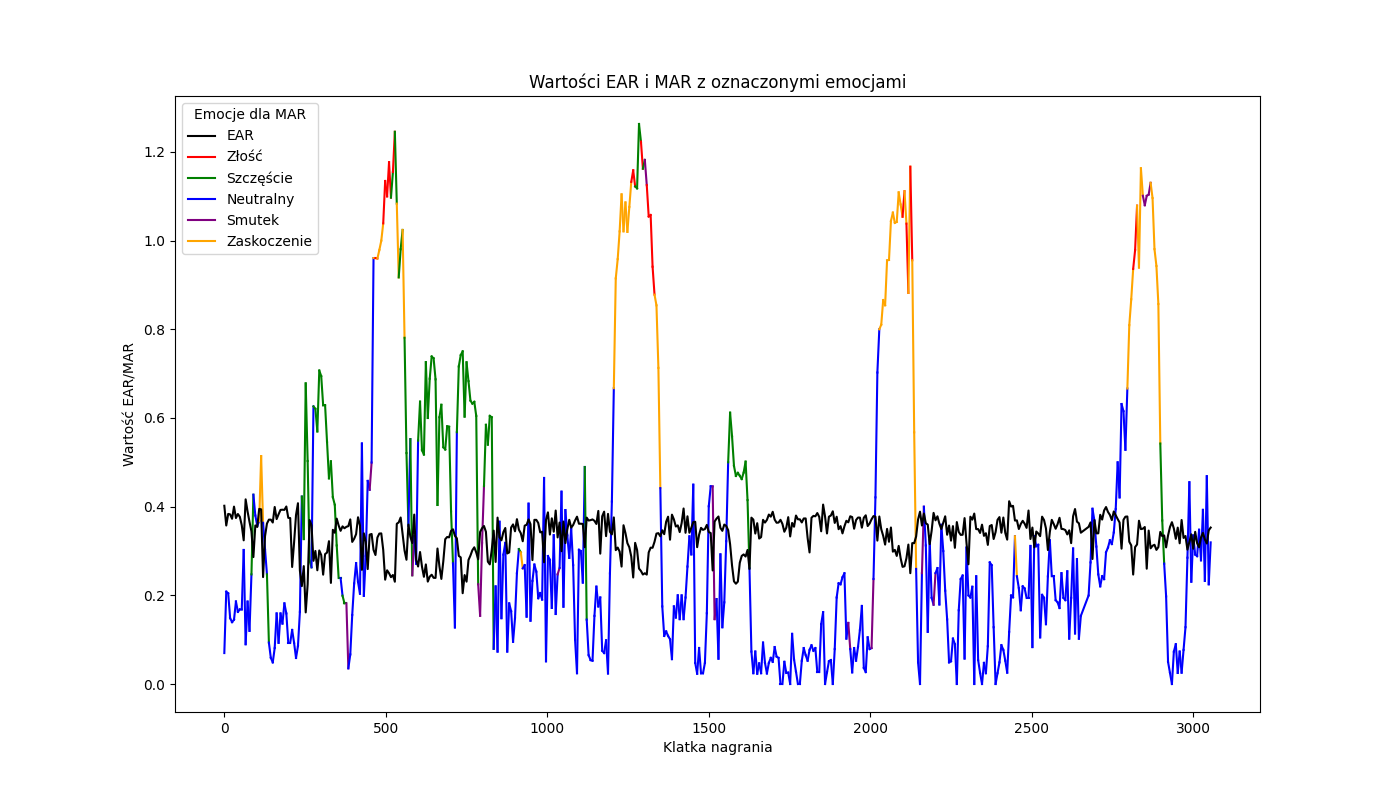

In [60]:
from IPython.display import Image
Image(filename=output_chart_path) 